In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

In [46]:
bd = pd.read_csv('final.csv')
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)

days_of_week = bd['finish_dttm'].dt.day_name()
days_of_week_num = bd['finish_dttm'].dt.weekday
bd['day_of_week'] = days_of_week
bd['num_of_week'] = days_of_week_num

def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
def percentsByRegion(bd, i):
    df = bd.copy()
    pt = df[df['region_size'] == i][df['age'] >= 18][df['age'] < 60][['age', 'flag']].pivot_table(index='age', columns='product_cd', values='flag', aggfunc=['sum', 'count'])
    # pt['percent'] = pt[(  'sum', 'flag')] / pt[('count', 'flag')] * 100
    # pt[pt['percent'] != 0]

bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)

bd = vibrosi(bd, 'confirmed_income', 43000)
bd = vibrosi(bd, 'predicted_income', 43000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 17)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)
df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)

# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

# Преобразуем finish_dttm в datetime, если нужно
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'])

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month
df['hours'] = df['finish_dttm'].dt.hour

df = vibrosi(df, 'hours', 21)
df = vibrosiVniz(df, 'hours', 6)

# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)


In [47]:
emp = df[['employee_id', 'emp_age', 'emp_age_new', 'emp_gender_cd', 'emp_children_cnt', 'emp_work_months_cnt', 'state_talk_time_sec', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).mean()
emp.reset_index(inplace=True)
emp['time_uspeh'] = 0

def ok(id):
    return df[df['flag'] == 1][df['employee_id'] == id]['state_talk_time_sec'].mean()

emp['time_uspeh'] = emp['employee_id'].apply(ok)

def min(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 25)

def max(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 75)

emp['min_age'] = emp['employee_id'].apply(min)
emp['max_age'] = emp['employee_id'].apply(max)

# 1. Считаем успешность по employee_id и gender_cd
success_rates = (
    df.groupby(['employee_id', 'gender_cd'])['flag']
    .mean()
    .reset_index()
    .rename(columns={'flag': 'success_rate'})
)

# 2. Для каждого employee_id выбираем gender_cd с максимальной успешностью
best_gender_per_employee = (
    success_rates.loc[success_rates.groupby('employee_id')['success_rate'].idxmax()]
    [['employee_id', 'gender_cd']]
    .rename(columns={'gender_cd': 'lovely_gender_cd'})
)

emp = emp.merge(best_gender_per_employee, on='employee_id', how='left')

# Рассчитываем процент успешности по каждому оператору и продукту
success_rate = df[['employee_id', 'product_cd', 'flag']].groupby(['employee_id', 'product_cd'])['flag'].mean().reset_index()
success_rate.rename(columns={'flag': 'success_rate'}, inplace=True)

# Для каждого оператора выбираем продукт с наибольшим процентом успешности
best_product = success_rate.loc[success_rate.groupby('employee_id')['success_rate'].idxmax()]

# Добавляем столбец best_product в исходный DataFrame
emp = emp.merge(best_product[['employee_id', 'product_cd']], on='employee_id', how='left')
emp.rename(columns={'product_cd': 'best_product'}, inplace=True)

emp = emp.rename({'flag' : 'emp_mean_flag'}, axis=1)

df_plus_emp = df.merge(emp[['employee_id', 'emp_mean_flag', 'time_uspeh', 'min_age', 'max_age', 'lovely_gender_cd', 'best_product']], on='employee_id', how='left')
df_plus_emp['emps_product'] = (df_plus_emp['product_cd'] == df_plus_emp['best_product']).astype(int)

df_plus_emp['female_matching'] = ((df_plus_emp['gender_cd'] == 'F') & (df_plus_emp['emp_gender_cd'] == 'W')).astype(int)
df_plus_emp['male_matching'] = ((df_plus_emp['gender_cd'] == 'M') & (df_plus_emp['emp_gender_cd'] == 'M')).astype(int)
df_plus_emp['gender_matching'] = ((df_plus_emp['female_matching'] == 1) | (df_plus_emp['male_matching'] == 1)).astype(int)
df_plus_emp['age_matching'] = ((df_plus_emp['age'] - df_plus_emp['emp_age']).abs() <= 5).astype(int)

df_plus_emp['lovely_gender_cd_encoded'] = (df_plus_emp['lovely_gender_cd'] == 'M').astype(int)

df_plus_emp['emps_lovely_age'] = ((df_plus_emp['min_age'] < df_plus_emp['age']) & (df_plus_emp['age'] < df_plus_emp['max_age'])).astype(int)

df_plus_emp['child_by_emp_and_cd_flg'] = ((df_plus_emp['child_amt'] > 0) * (df_plus_emp['emp_children_cnt'] > 0)).astype(int)

def sha_budet_rok(x):
    if x <= 25:
        return '14-25'
    elif x <= 35:
        return '26-35'
    elif x <= 45:
        return '36-45'
    elif x <= 60:
        return '45-60'
    else:
        return '60-80'

def sha_budet_rok2(x):
    if x <= 25:
        return 0
    elif x <= 35:
        return 1
    elif x <= 45:
        return 2
    elif x <= 60:
        return 3
    else:
        return 4


def liza_prosto_zaputalas_v_oboznacheniyah(x):
    if x == 1:
        return 'Гендеры совпадают'
    if x == 0:
        return 'Гендеры разные'

df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_group_matching'] = (df_plus_emp['age_groups_cd'] == df_plus_emp['age_groups_emp']).astype(int)
df_plus_emp['pol_sovpadenie'] = df_plus_emp['gender_matching'].apply(lambda x: liza_prosto_zaputalas_v_oboznacheniyah(x))

In [48]:
# Функция для получения нижней границы группы
def extract_min_age(group):
    return int(group.split('-')[0])

# Преобразуем группы в числовые значения (нижняя граница)
df_plus_emp['emp_group_min'] = df_plus_emp['age_groups_emp'].apply(extract_min_age)
df_plus_emp['client_group_min'] = df_plus_emp['age_groups_cd'].apply(extract_min_age)

df_plus_emp['matching_variance'] = np.where(df_plus_emp['emp_group_min'] > df_plus_emp['client_group_min'], 'Оператор старше клиента',
                                   np.where(df_plus_emp['emp_group_min'] == df_plus_emp['client_group_min'], 'Одинаковый возраст', 'Клиент старше операторa'))

# Удаляем временные столбцы, если они не нужны
df_plus_emp.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

In [39]:
df_plus_emp['matching_variance'].value_counts()

matching_variance
Клиент старше операторa    6808
Оператор старше клиента    4635
Одинаковый возраст         3353
Name: count, dtype: int64

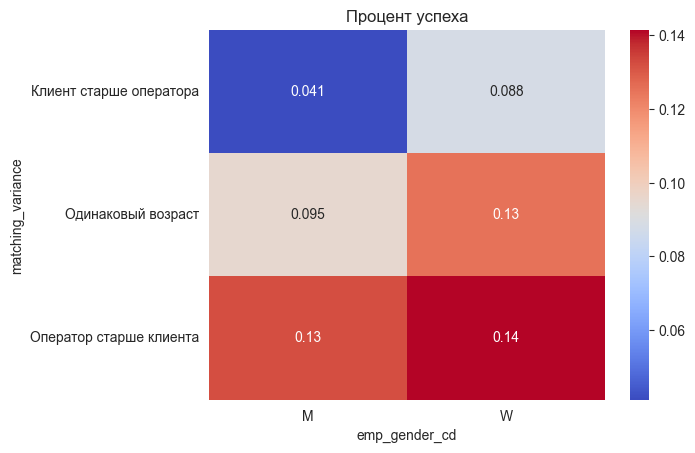

In [6]:
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()
pivot = cc.pivot_table(index='matching_variance' , values='flag', columns='emp_gender_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

<Axes: >

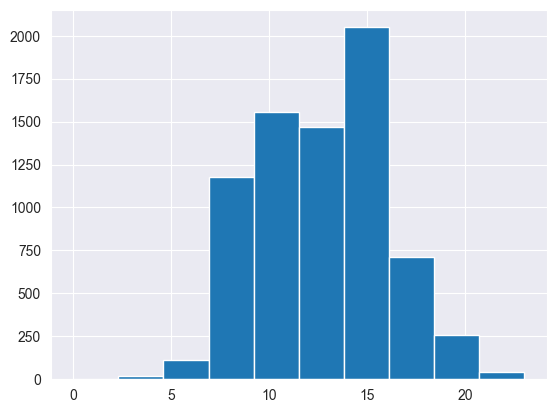

In [35]:
cc['hours'].hist()

In [154]:
cc.shape[0]

7401

In [8]:

def matching_heatmap(df_plus_emp):
    pivot = df_plus_emp.pivot_table(values='flag', index='matching_variance', columns='emp_gender_cd', aggfunc='mean')
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title('Процент успеха')
    plt.show()

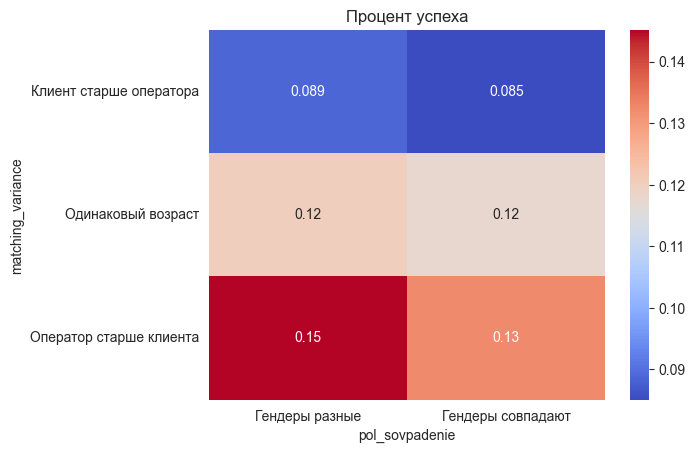

In [70]:
matching_heatmap(cc)

In [9]:
bd = pd.read_csv('final.csv')
bd['income'] = bd['confirmed_income'].fillna(bd['predicted_income'])

<Axes: >

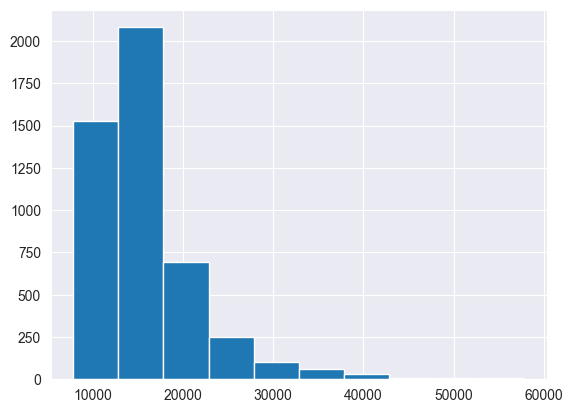

In [20]:
bd['income'][bd['income'] < 60000][bd['income'] > 0].hist()

In [31]:
bd = pd.read_csv('final.csv')
bd['income'] = bd['confirmed_income'].fillna(bd['predicted_income'])

# Преобразуем finish_dttm в datetime, если нужно
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])

# Извлекаем номер месяца
bd['month'] = bd['finish_dttm'].dt.month
bd['hours'] = bd['finish_dttm'].dt.hour
bd[bd['income'] < 100000][bd['income'] > 0].pivot_table(index='income', values='customer_id', aggfunc='count')

,customer_id
income,
7823.50,78
7825.04,1
7826.01,1
7827.84,1
7829.53,1
...,...
78476.15,1
79270.56,1
85787.68,1


In [71]:
cash_loan = df_plus_emp[df_plus_emp['product_cd'] == 'Cash Loan'].copy()
cash_loan['age_plus_gender_matching'] = ((cash_loan['matching_variance'] == 'Оператор старше клиента') & (cash_loan['gender_matching'] == 0))

from scipy.stats import chi2_contingency

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(cash_loan['age_plus_gender_matching'], cash_loan['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")

Хи-квадрат статистика: 5.495593417166699
p-value: 0.019064456562923264
Гипотеза подтверждена: низкий доход влияет на успешность апселла


Хи-квадрат статистика: 27.930775229435216
p-value: 1.2573397992781502e-07
Гипотеза подтверждена: низкий доход влияет на успешность апселла

Результаты теста Тьюки:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     0      1   0.0652   0.0 0.0412 0.0891   True
-------------------------------------------------



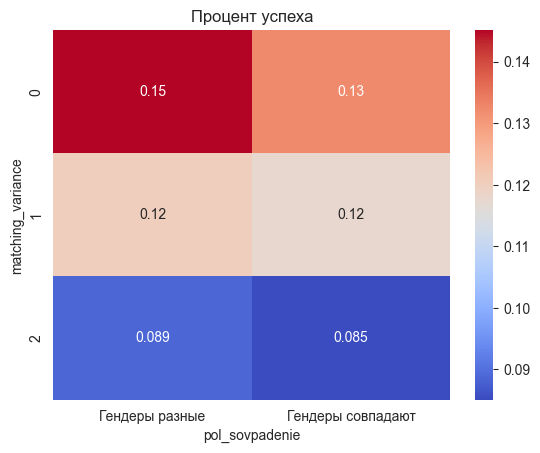

Odds Ratio: 0.9543790202869866, P-value: 0.6755368201740436


In [117]:
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards','Cash Loan', 'Secured Loan', 'Car Loan'])].copy()
cc['age_plus_gender_matching'] = ((cc['matching_variance'] == 'Оператор старше клиента') & (cc['gender_matching'] == 0))

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(cc['age_plus_gender_matching'], cc['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")
    
# Пост-хок анализ Тьюки
data_long = cc.explode('flag')
tukey = pairwise_tukeyhsd(endog=data_long['age_plus_gender_matching'], groups=data_long['flag'], alpha=0.05)

print("\nРезультаты теста Тьюки:")
print(tukey)

# Преобразуем группы в числовые значения (нижняя граница)
cc['emp_group_min'] = cc['age_groups_emp'].apply(extract_min_age)
cc['client_group_min'] = cc['age_groups_cd'].apply(extract_min_age)

cc['matching_variance'] = np.where(cc['emp_group_min'] > cc['client_group_min'], 0,
                                   np.where(cc['emp_group_min'] == cc['client_group_min'], 1, 2))

# Удаляем временные столбцы, если они не нужны
cc.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

cc['age_plus_gender_matching'] = cc['matching_variance']*2 + cc['gender_matching']
print()

matching_heatmap(cc)

from scipy.stats import fisher_exact
# cc['age_plus_gender_matching'] = ((cc['matching_variance'] == 'Оператор старше клиента') & (cc['gender_matching'] == 0))
# Создание таблицы сопряженности
contingency_table = pd.crosstab(cc[cc['age_plus_gender_matching'].isin([5, 4])]['age_plus_gender_matching'], 
                                cc[cc['age_plus_gender_matching'].isin([5, 4])]['flag'])

# Точный тест Фишера
odds_ratio, p_value = fisher_exact(contingency_table)
print(f"Odds Ratio: {odds_ratio}, P-value: {p_value}")



In [120]:
df_plus_emp[df_plus_emp['emp_gender_cd'] == 'W'].shape[0] / (df_plus_emp[df_plus_emp['emp_gender_cd'] == 'W'].shape[0] + df_plus_emp[df_plus_emp['emp_gender_cd'] == 'M'].shape[0])

0.8214285714285714

In [109]:
contingency_table

flag,0,1
age_plus_gender_matching,,
4,2886,470


In [74]:
contingency_table.loc[[0, 1], [0, 1]]

flag,0,1
s,,
0,2411,235
1,1849,172


In [88]:
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards','Cash Loan', 'Secured Loan', 'Car Loan'])].copy()
cc['region_size'].value_counts()

region_size
town     3588
urban    1548
msk       921
rural     653
Name: count, dtype: int64

26-35, Credit Cards: 1958


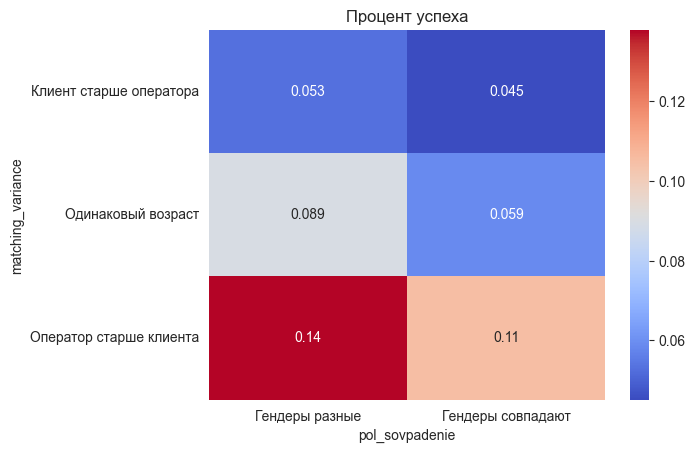

36-45, Credit Cards: 2069


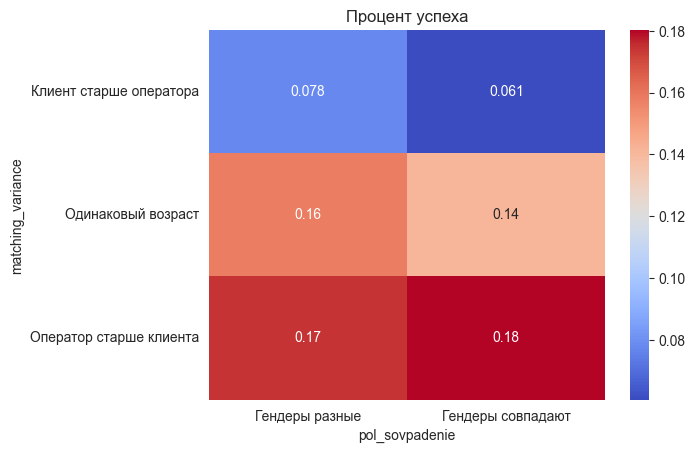

45-60, Credit Cards: 1509


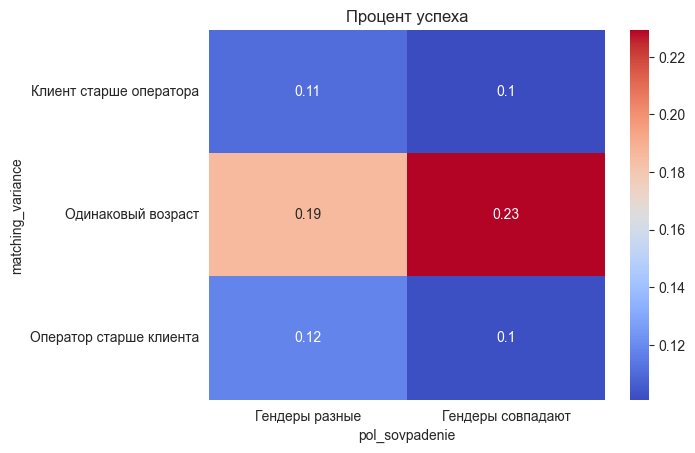

14-25, Credit Cards: 1328


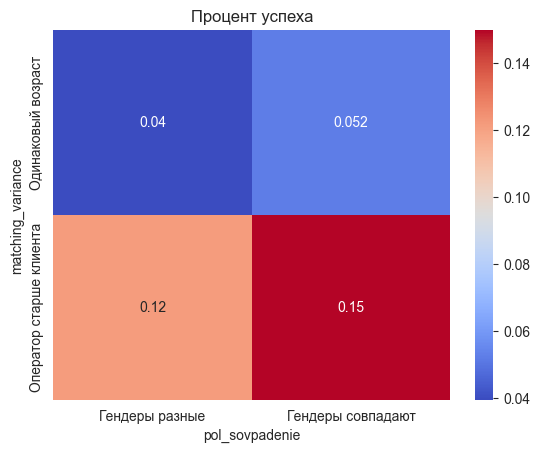

60-80, Credit Cards: 537


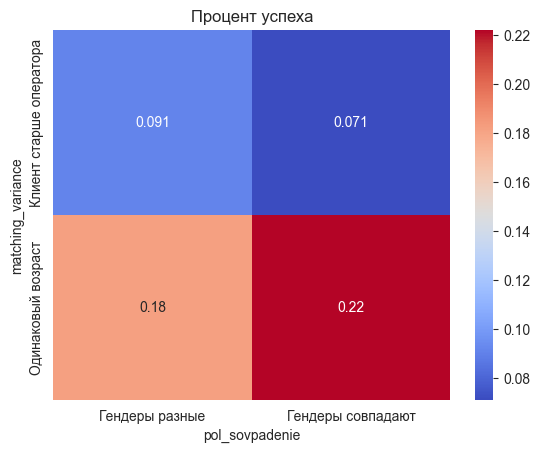

26-35, Cash Loan: 736


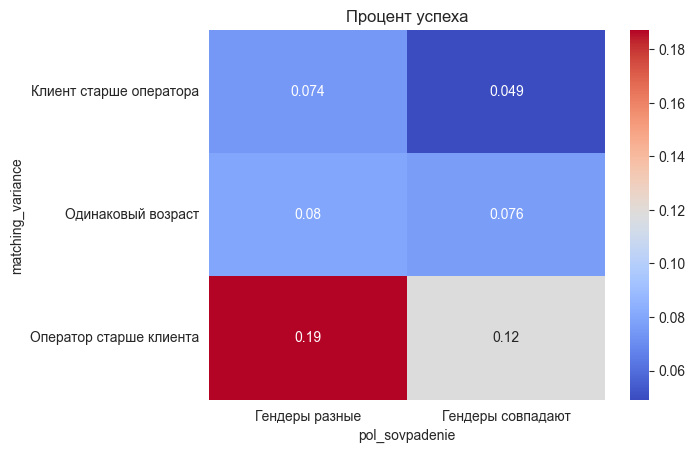

36-45, Cash Loan: 700


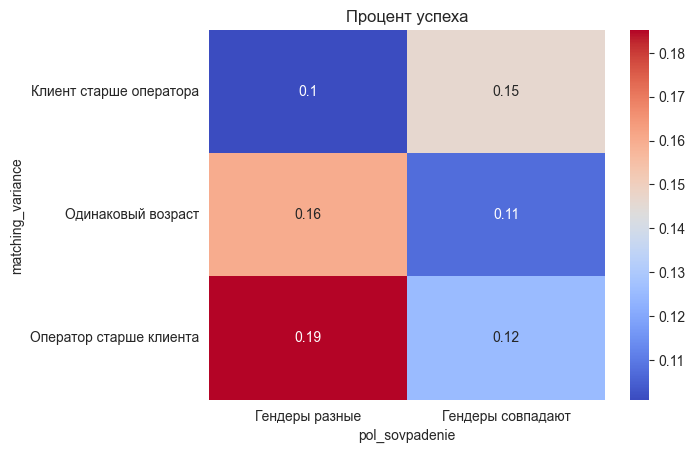

45-60, Cash Loan: 446


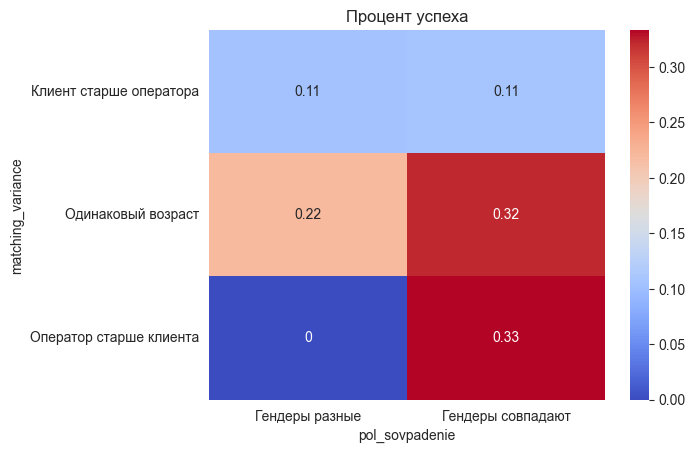

14-25, Cash Loan: 410


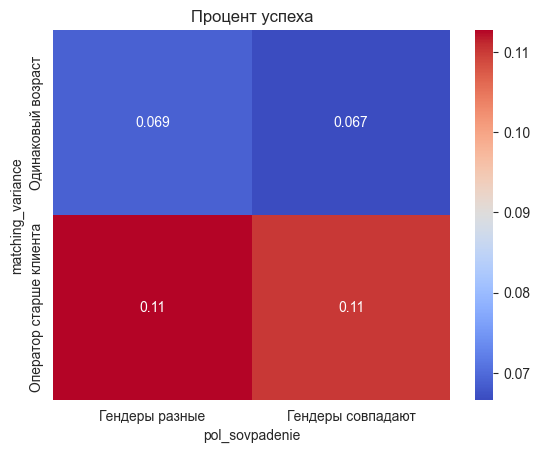

60-80, Cash Loan: 110


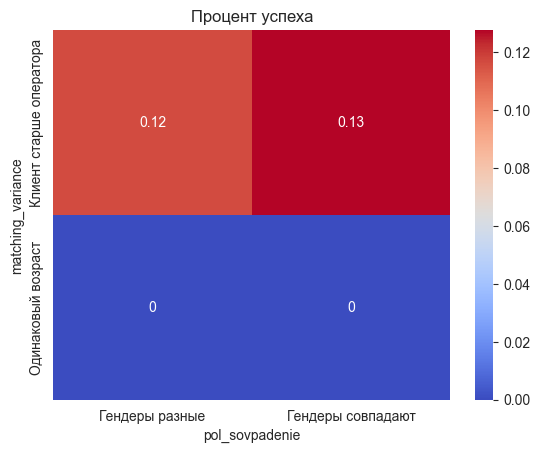

26-35, Debit Cards: 391


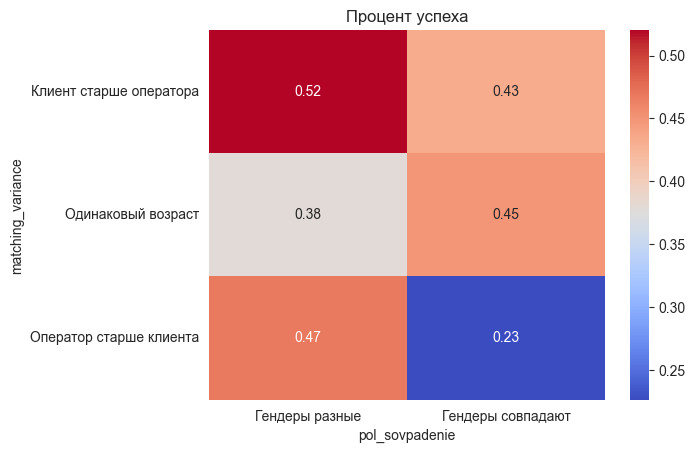

36-45, Debit Cards: 414


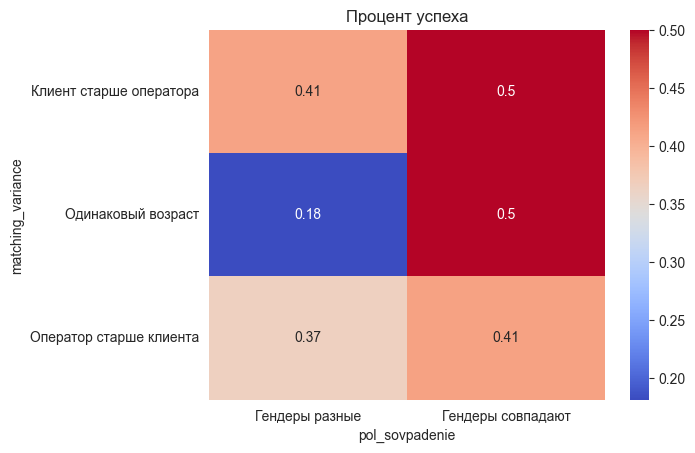

45-60, Debit Cards: 264


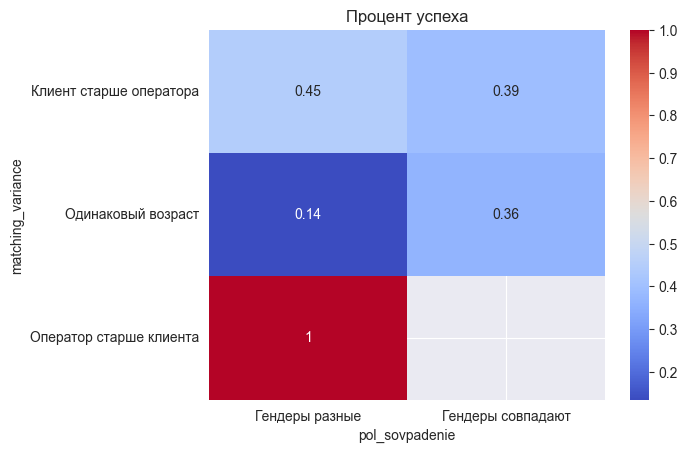

14-25, Debit Cards: 335


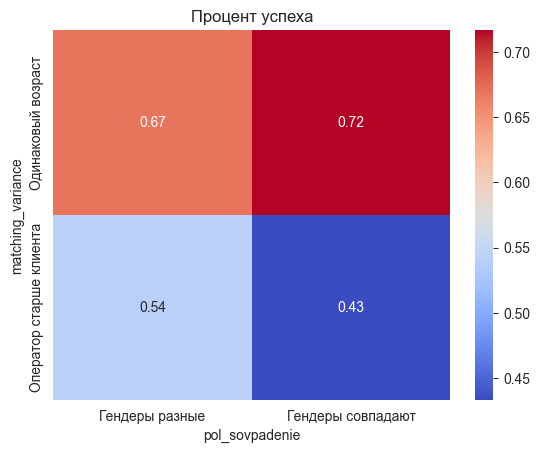

60-80, Debit Cards: 125


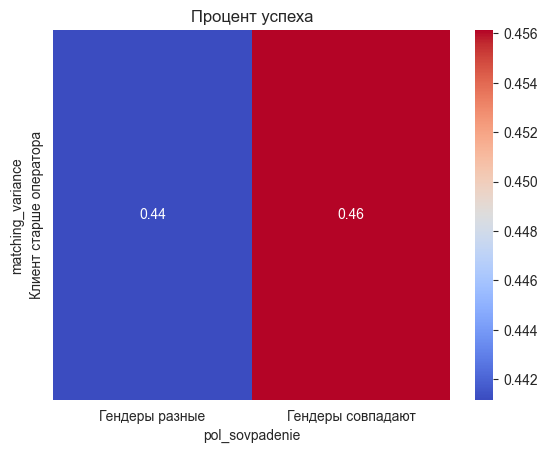

In [45]:
products = ['Credit Cards', 'Cash Loan', 'Debit Cards']
for j in products:
    for i in df_plus_emp['age_groups_cd'].unique():
        x = df_plus_emp[df_plus_emp['age_groups_cd'] == i][df_plus_emp['product_cd'] == j]
        if x.shape[0] == 0:
            continue
        
        print(f'{i}, {j}: {x.shape[0]}')
        matching_heatmap(x)

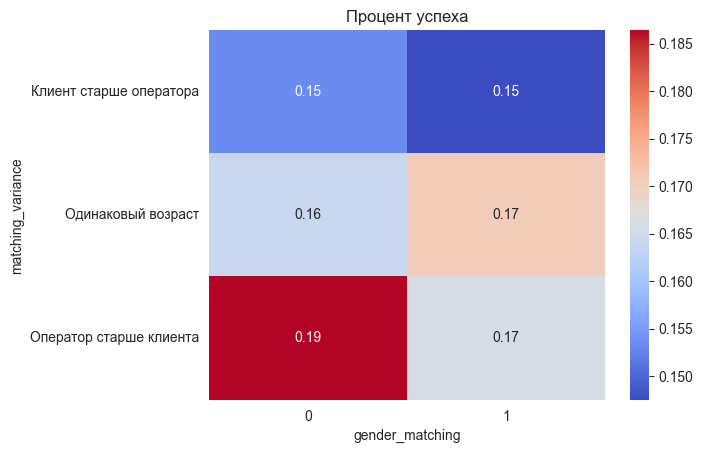

In [26]:
matching_heatmap(df_plus_emp)

Credit Cards: 7401


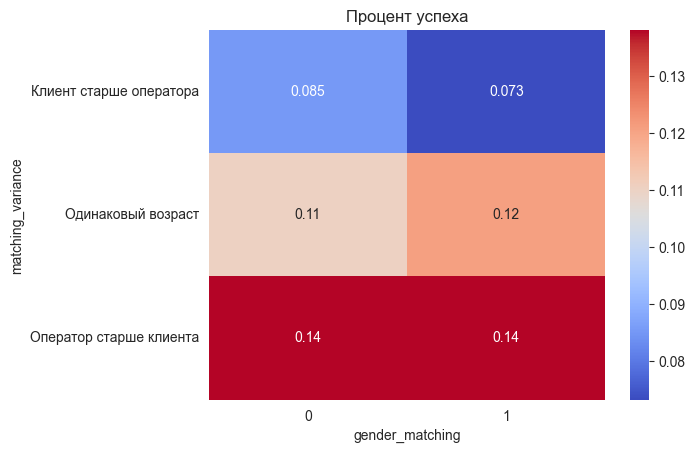

Cash Loan: 2402


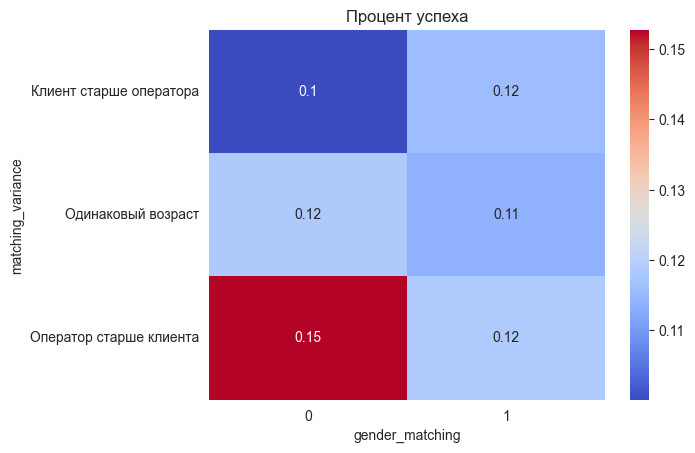

MVNO: 1652


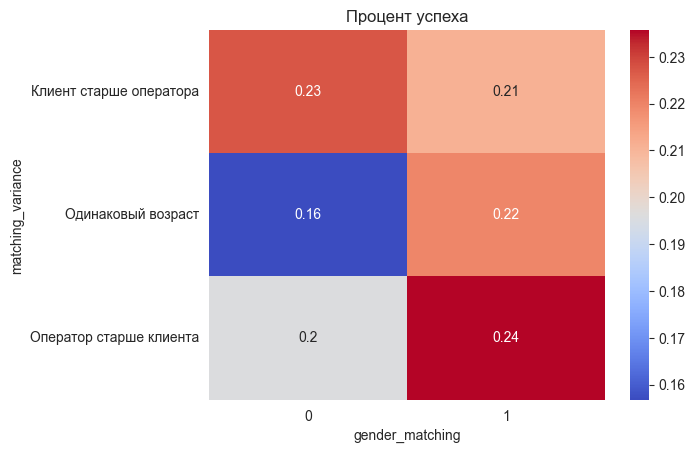

Debit Cards: 1529


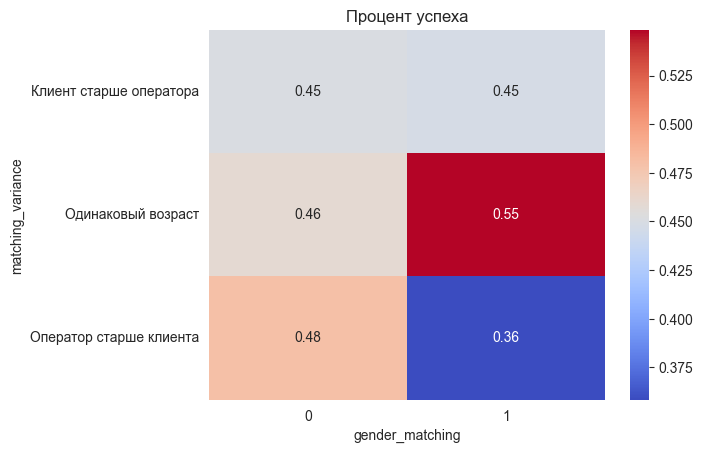

Investment: 565


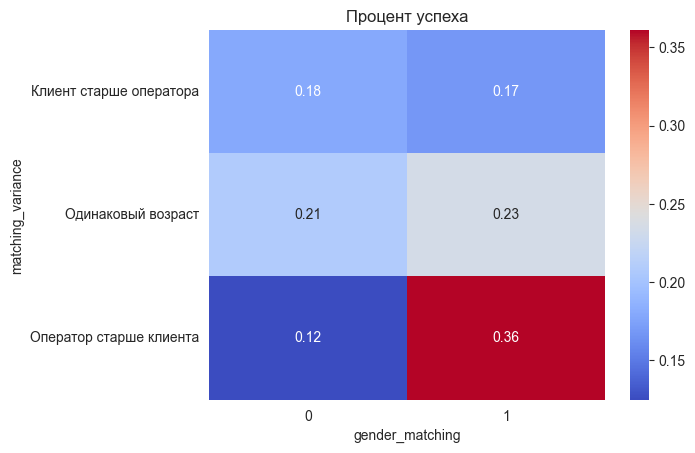

Secured Loan: 435


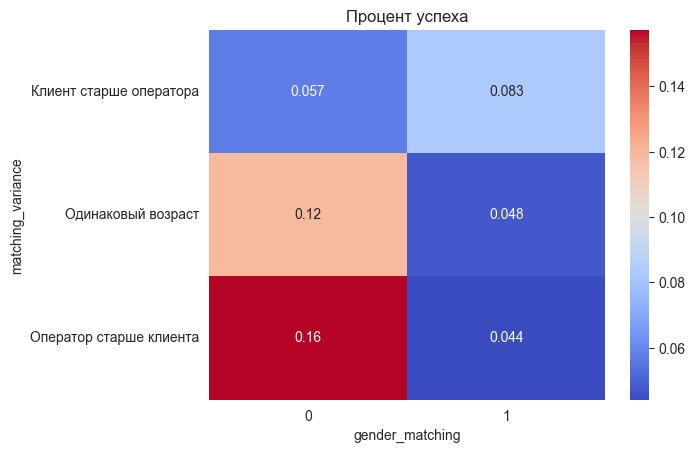

In [25]:
products = ['Credit Cards', 'Cash Loan', 'MVNO', 'Debit Cards', 'Investment', 'Secured Loan']
for i in products:
    k = df_plus_emp[df_plus_emp['product_cd'] == i].shape[0]
    print(f'{i}: {k}')
    matching_heatmap(df_plus_emp[df_plus_emp['product_cd'] == i])

In [12]:
df_plus_emp['age_plus_gender_matching'] = ((df_plus_emp['matching_variance'] == -1) & (df_plus_emp['gender_matching'] == 0))

In [21]:
df_plus_emp['product_cd'].value_counts()

product_cd
Credit Cards          7401
Cash Loan             2402
MVNO                  1652
Debit Cards           1529
Investment             565
Secured Loan           435
Casco                  291
Mortgage Insurance     246
Car Loan               237
Osago                   23
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

In [13]:
from scipy.stats import chi2_contingency

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(df_plus_emp['age_plus_gender_matching'], df_plus_emp['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")

Хи-квадрат статистика: 13.682668897799541
p-value: 0.00021644277507797946
Гипотеза подтверждена: низкий доход влияет на успешность апселла


In [6]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

g1 = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards', 'Cash Loan', 'Secured Loan', 'Car Loan'])][['flag', 'gender_cd', 'gender_match', 'auto_flg', 'emp_gender_cd', 'partnership_flg', 'emp_age_new', 'emp_work_months_cnt', 'age', 'income', 'child_flg', 'emps_lovely_age', 'realty_type', 'lovely_gender_cd_encoded', 'age_group_matching']]

logit_res = smf.glm('flag ~ C(gender_cd) + C(gender_match) + C(auto_flg) + C(emp_gender_cd) + C(partnership_flg) + C(realty_type) \
+ emp_age_new + emp_work_months_cnt + age + income + C(child_flg) + C(lovely_gender_cd_encoded) + C(age_group_matching)', g1, family = sm.families.Binomial()).fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   flag   No. Observations:                 1943
Model:                            GLM   Df Residuals:                     1927
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -599.02
Date:                Tue, 10 Dec 2024   Deviance:                       1198.0
Time:                        21:49:25   Pearson chi2:                 1.87e+03
No. Iterations:                    21   Pseudo R-squ. (CS):            0.05374
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -3.4220      0.941     -3.638      0.000      -5.266      -1.578
C(gender_cd)[T.M]                     -0.0455      0.168     -0.271      0.786      -0.375       0.284
C(gender_match)[T.1]                  -0.4702      0.556     -0.846      0.398      -1.560       0.620
C(auto_flg)[T.1.0]                     0.1078      0.166      0.649      0.517      -0.218       0.433
C(emp_gender_cd)[T.W]                 -0.1772      0.380     -0.467      0.641      -0.921       0.567
C(partnership_flg)[T.1.0]              0.1426      0.210      0.680      0.497      -0.268       0.554
C(realty_type)[T.Квартира]            -0.5217      0.788     -0.662      0.508      -2.066       1.022
C(realty_type)[T.Комната]            -20.5282   1.31e+04     -0.002      0.999   -2.56e+04    2.56e+04
C(realty_type)[T.Нет своего жилья]    -0.3527      0.786     -0.449      0.654      -1.893       1.188
C(child_flg)[T.1]                     -0.1969      0.178     -1.103      0.270      -0.547       0.153
C(lovely_gender_cd_encoded)[T.1]      -0.3087      0.159     -1.937      0.053      -0.621       0.004
C(age_group_matching)[T.1]             0.2253      0.180      1.248      0.212      -0.128       0.579
emp_age_new                            0.0236      0.006      3.837      0.000       0.012       0.036
emp_work_months_cnt                    0.0151      0.002      6.678      0.000       0.011       0.020
age                                    0.0147      0.007      2.029      0.042       0.001       0.029
income                             -2.299e-06   1.43e-05     -0.161      0.872   -3.03e-05    2.57e-05
======================================================================================================
"""

In [8]:
from scipy.stats import chi2_contingency

def KOSTIL(df, i, j):
    while i <= j:
        df = df[df['num_segment'] != i]
        i += 1
    return df

df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell', 'Downsell'])]

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(df_plus_emp['age_group_matching'], df_plus_emp['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")

Хи-квадрат статистика: 0.3852649801183855
p-value: 0.534798890061345
Гипотеза не подтверждена: связь между доходом и успешностью отсутствует


In [9]:
df_plus_emp['product_cd'].value_counts()

product_cd
Credit Cards          7401
Cash Loan             2402
MVNO                  1652
Debit Cards           1529
Investment             565
Secured Loan           435
Casco                  291
Mortgage Insurance     246
Car Loan               237
Osago                   23
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

In [97]:
from scipy.stats import chi2_contingency
from itertools import combinations

def KOSTIL(df, i, j):
    while i <= j:
        df = df[df['num_segment'] != i]
        i += 1
    return df

products = ['Credit Cards', 'Cash Loan', 'MVNO', 'Secured Loan', 'Car Loan', 'Debit Cards', 'Investment', 'Casco', 'Mortgage Insurance']
p_val = 123
ibest = -1
best = {}
lol = []

for i in range(1, 10):
    all_combinations = list(combinations(products, i))
    for wtf in all_combinations:
        df_credit = df_plus_emp[df_plus_emp['product_cd'].isin(wtf)].copy()
        if i != 1 and df_credit.shape[0] < 800:
            continue
        contingency_table = pd.crosstab(df_credit['male_matching'], df_credit['flag'])
        
        # Тест хи-квадрат
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        if i == 1:
            print(f'{wtf[0]}: {p:.3f}')
        
        if df_credit.shape[0] < 800:
            continue
        
        if p < 0.05:
            for j in wtf:
                if j not in best:
                    best[j] = 1
                else:
                    best[j] += 1
        
        if p < p_val:
            p_val = p
            ibest = i
            lol = wtf
    print(f'{i/9*100:.4}%')


df_credit = df_plus_emp[df_plus_emp['product_cd'].isin(lol)].copy()
contingency_table = pd.crosstab(df_credit['male_matching'], df_credit['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print(f"Хи-квадрат статистика: {chi2:.3f}")
print(f"p-value: {p:.3f}")
print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадения гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между совпадением гендеров и успешностью отсутствует")

print()
for i in best:
    print(f'{i}: {best[i]}')

Credit Cards: 0.024
Cash Loan: 0.887
MVNO: 0.000
Secured Loan: 0.110
Car Loan: 0.362
Debit Cards: 0.007
Investment: 0.468
Casco: 0.310
Mortgage Insurance: 0.090
11.11%
22.22%
33.33%
44.44%
55.56%
66.67%
77.78%
88.89%
100.0%
Хи-квадрат статистика: 23.377
p-value: 0.000
product_cd: ('Cash Loan', 'MVNO', 'Investment')
Гипотеза подтверждена: совпадения гендеров влияет на успешность звонка

Credit Cards: 85
MVNO: 130
Debit Cards: 53
Cash Loan: 90
Secured Loan: 94
Car Loan: 94
Mortgage Insurance: 94
Investment: 81
Casco: 90


In [149]:
df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
df_credit.shape[0]

10152

In [258]:
import pandasql as ps


df_credit = df_plus_emp.copy()
df_credit = df_credit.reset_index()

q1 = """
SELECT * FROM df_credit
WHERE "index" NOT IN (
    SELECT "index" FROM df_credit
    WHERE "wo_hit_status_reason_desc" IN (
        "Другое", "Третье лицо", "Отказ по всем продуктам", 
        "Не хочет разбираться", "Устраивает свой оператор",
        "Не интересно", "Другой банк", "Действующий клиент",
        "Клиент ранее отказался", "Другое (нестандартная ситуация)",
        "Уже является абонентом Т-Мобайл", "Сам разберется",
        "Не соответствует по возрасту", "Уже оставил заявку",
        "Не требуется сейчас", "Нет потребности",
        "Не соответствует по возрасту", "Другое;Обратится самостоятельно",
        "Пользуется картой другого банка", "Уже является абонентом Т-Мобайла",
        "Кредит / КК в другом банке", "Другое;Отказ от маркетинговых коммуникаций",
        "Другое (укажи в комментарии)", "Перезвонит самостоятельно",
        "Уже является абонентом ТМ", "Некорректный трансфер",
        "Не соответствует требованиям", "Уже застрахован",
        "Пользуется другим брокером", "Уже утилизирован",
        "Просто интересовался условиями", "Другое;Дубль заявки",
        "Взял кредит в другом банке", "3 лицо;Не знаком с клиентом, 3-е лицо",
        "Пользуется сим другого провайдера", "Отказ от маркетинговых коммуникаций",
        "Другое;Действующий клиент. Вопрос по текущему продукту, нецелевому кейсу",
        "В списке нет подходящей причины", "Уже продлил в Тинькофф чаты/МП",
        "Некорректно передан из офиса", "Отказ предоставить персональные данные",
        "3 лицо;Номер не принадлежит страхователю", "Отказ предоставить данные для заявки",
        "Другое;Перевод в офис (нестандартная ситуация)", "В списке нет подходящей причины (укажи в комментариях)",
        "Сложный кейс"
    )
)
"""

df_credit = ps.sqldf(q1, locals())
df_credit.shape[0]

10286

In [165]:
# df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
contingency_table = pd.crosstab(df_credit['flag'], df_credit['gender_matching'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадения возрастной группы влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 2.1997547163183198
p-value: 0.13803270008962182
product_cd: ('Cash Loan', 'MVNO', 'Investment')
Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует


In [152]:
df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])][['gender_cd', 'gender_matching', 'flag']].groupby(by=['gender_cd', 'gender_matching']).mean()

flag
gender_cd gender_matching          
F         0                0.109818
          1                0.121285
M         0                0.140984
          1                0.159255

In [153]:
contingency_table

gender_matching,0,1
flag,,
0,3464,2622
1,785,557


In [26]:
df_plus_emp['flag'].mean()

np.float64(0.16308461746417952)

In [145]:
df_credit[df_credit['gender_matching'] == 1]['flag']

0       0
1       0
2       0
3       0
4       0
       ..
2719    0
2720    0
2721    0
2722    0
2723    0
Name: flag, Length: 2724, dtype: int64

In [67]:
for i in df['functional_cd'].unique():
    print(f'{i}: ')

Meeting: 
Agreement: 
Upsell: 
Afterfilling: 
Cold: 
Preapprove: 
Activation: 
Utilization: 
Downsell: 
Reutilization: 
BAF: 
Autoleads: 
Prolongation: 
Incoming: 
Deposit: 
Refinancing: 


In [262]:
df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
df_gypotesa_1 = df_credit[df_credit['product_cd'] == 'Credit Cards'].copy()
df_gypotesa_1['age35'] = (df_gypotesa_1['age'] > 35).astype(int)

contingency_table = pd.crosstab(df_gypotesa_1['age35'], df_gypotesa_1['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 12.995776677666637
p-value: 0.0003121943282342346
Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка


In [263]:
df_credit[[ 'age_groups_emp', 'emp_work_months_cnt']].groupby(by=['age_groups_emp']).agg(['mean', 'count'])

emp_work_months_cnt      
                              mean count
age_groups_emp                          
14-25                     4.876048  3340
26-35                    17.795648  1884
36-45                    34.358670  1684
45-60                    38.422692  1798
60+                      34.881395   430

In [81]:
df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])]['flag'].mean()

np.float64(0.1328802206461781)

In [139]:
df_credit[df_credit['emp_gender_cd'] == 'M'][df_credit['gender_cd'] == 'M']

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,female_matching,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching
7,1606,410196959,18.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,14-25,26-35,0
31,5380,309284298,34.0,M,rural,0.0,0.0,1.0,1.0,1.0,...,0,1,1,0,1,0,0,26-35,26-35,1
38,6767,531272054,48.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,0,0,0,45-60,14-25,0
48,7357,516349639,31.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,1,0,26-35,14-25,0
51,7889,303643007,38.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,1,0,36-45,14-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,18555,387456657,51.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,0,0,45-60,14-25,0
2679,18568,333820766,16.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,0,0,14-25,14-25,1
2680,18578,129875643,31.0,M,urban,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,0,0,26-35,14-25,0
2686,18627,214597107,26.0,M,town,0.0,0.0,0.0,0.0,1.0,...,0,1,1,0,1,0,0,26-35,14-25,0


In [107]:
df_plus_emp[df_plus_emp['functional_cd'] == 'Utilization']['product_cd'].unique()

array(['Investment', 'Credit Cards', 'Debit Cards', 'MVNO'], dtype=object)

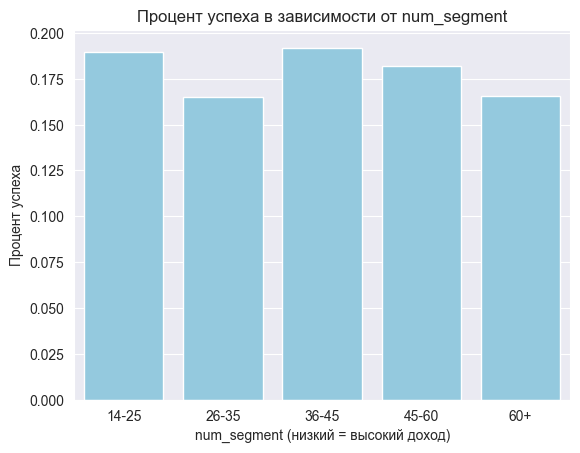

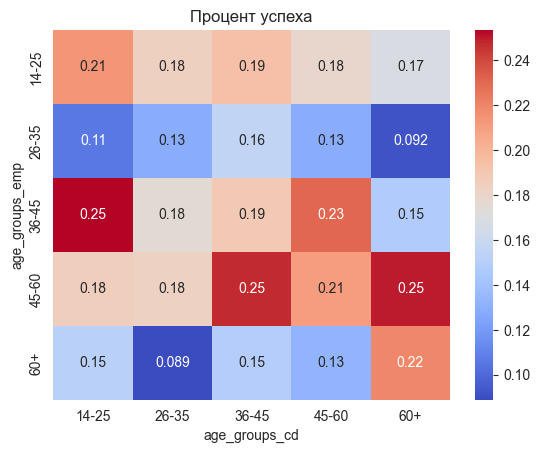

In [173]:
# Группировка по num_segment
success_by_segment = df_credit.groupby('age_groups_cd')['flag'].mean().reset_index()

# Визуализация успеха по num_segment
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='age_groups_cd', y='flag', data=success_by_segment, color='skyblue')
plt.title('Процент успеха в зависимости от num_segment')
plt.xlabel('num_segment (низкий = высокий доход)')
plt.ylabel('Процент успеха')
plt.show()

# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='age_groups_emp', columns='age_groups_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

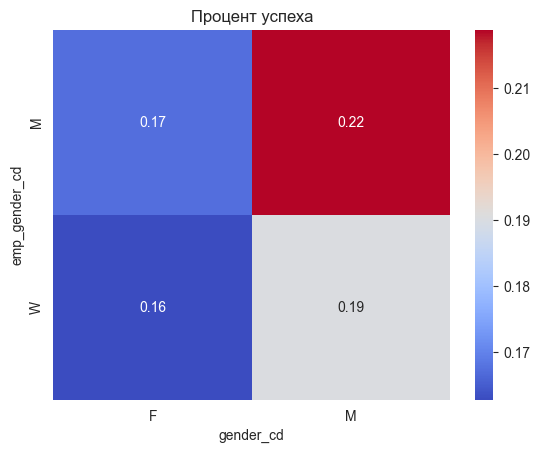

In [176]:
# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='emp_gender_cd', columns='gender_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

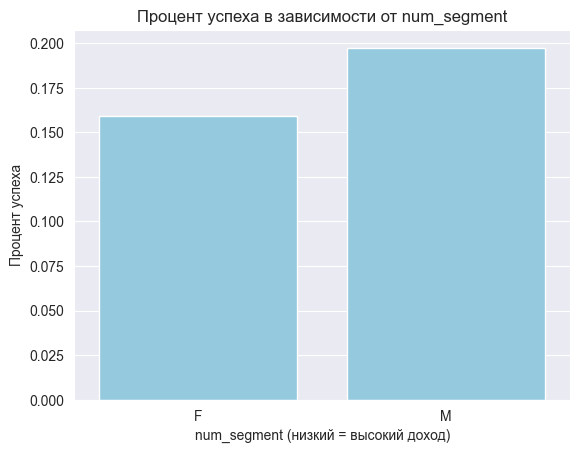

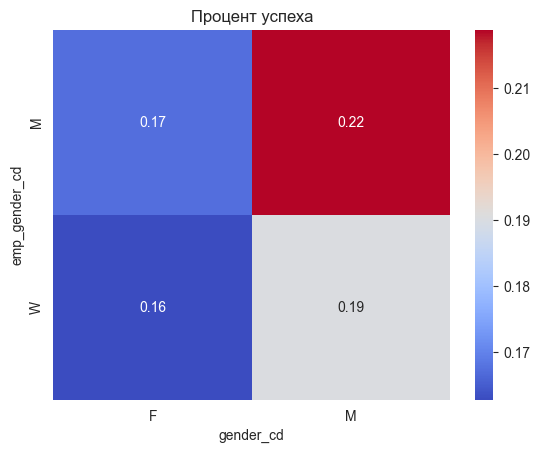

In [169]:
# Группировка по num_segment
success_by_segment = df_credit.groupby('gender_cd')['flag'].mean().reset_index()

# Визуализация успеха по num_segment
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='gender_cd', y='flag', data=success_by_segment, color='skyblue')
plt.title('Процент успеха в зависимости от num_segment')
plt.xlabel('num_segment (низкий = высокий доход)')
plt.ylabel('Процент успеха')
plt.show()

# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='emp_gender_cd', columns='gender_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

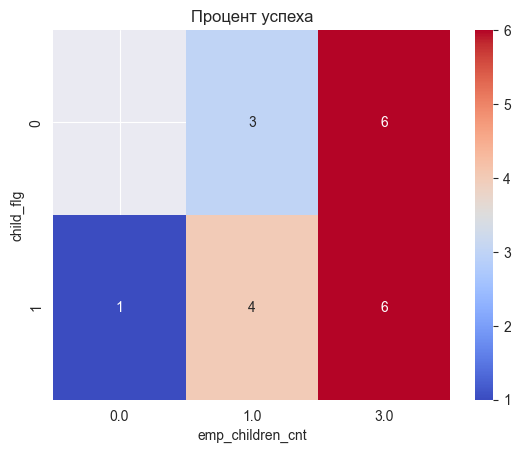

In [178]:
pivot = df_credit.pivot_table(values='flag', index='child_flg', columns='emp_children_cnt', aggfunc='count')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

In [180]:
df_credit[df_credit['child_flg'] == 0]

,index,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,...,female_matching,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching
1,21,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,...,1,0,1,0,1,0,0,14-25,60+,0
3,30,1187,397419981,34.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,26-35,14-25,0
4,32,1219,506166284,24.0,F,town,0.0,1.0,0.0,0.0,...,1,0,1,0,1,1,0,14-25,36-45,0
5,37,1332,285227095,23.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,14-25,14-25,1
6,38,1338,68791731,33.0,F,town,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,0,26-35,60+,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,14759,14213,523479311,NaN,None,rural,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,60+,36-45,0
7416,14771,16372,572944033,NaN,None,town,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,60+,36-45,0
7417,14772,16374,420501254,NaN,F,urban,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,60+,36-45,0
7424,14787,17761,371460142,NaN,None,rural,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,60+,14-25,0


In [ ]:
# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(df_plus_emp['age_plus_gender_matching'], df_plus_emp['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")

Casco: 207


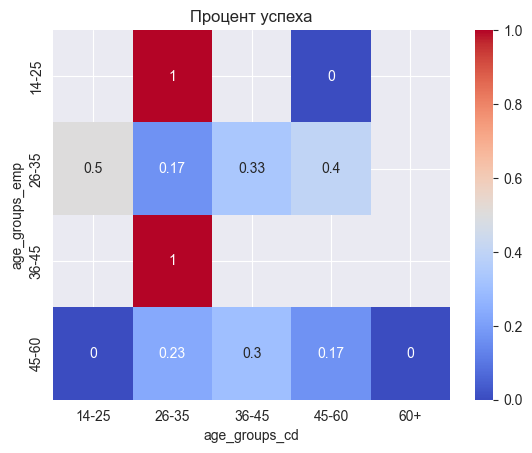

Credit Cards: 5541


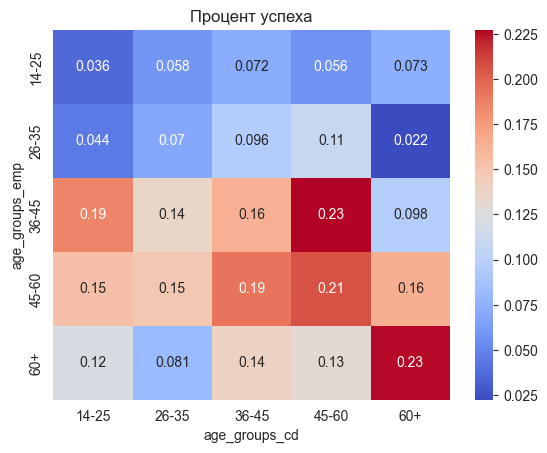

Cash Loan: 663


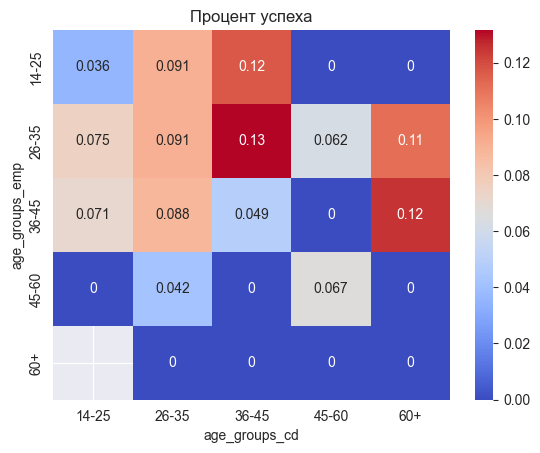

MVNO: 271


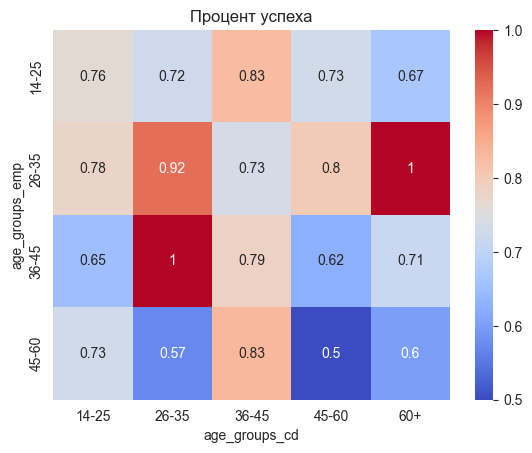

Mortgage Insurance: 24


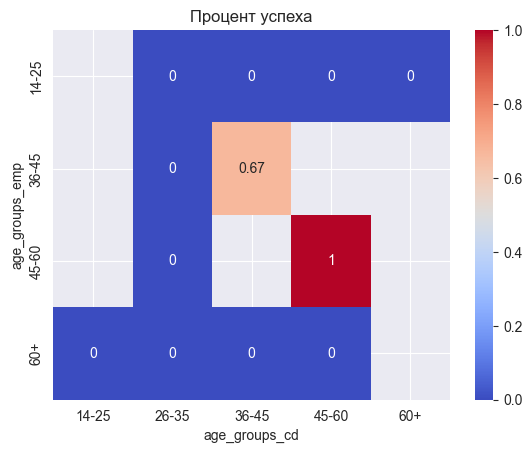

Investment: 143


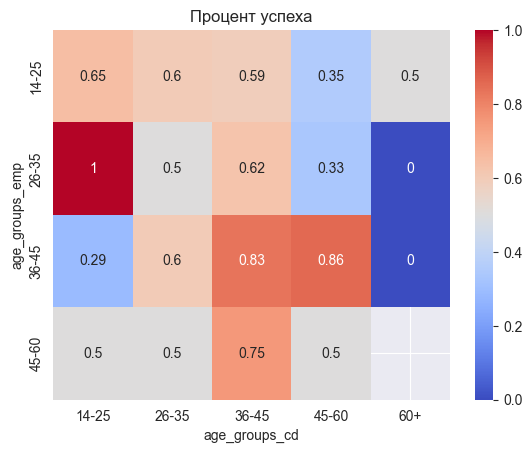

Car Loan: 60


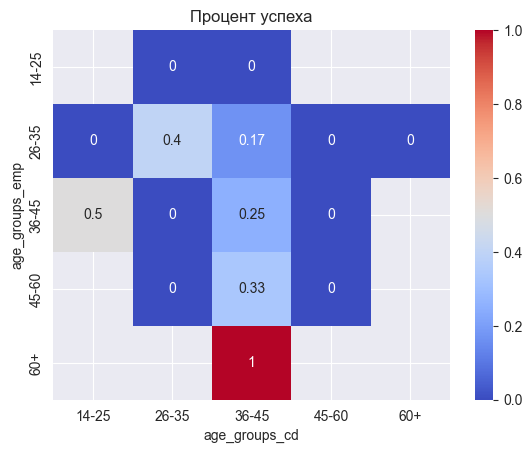

Debit Cards: 506


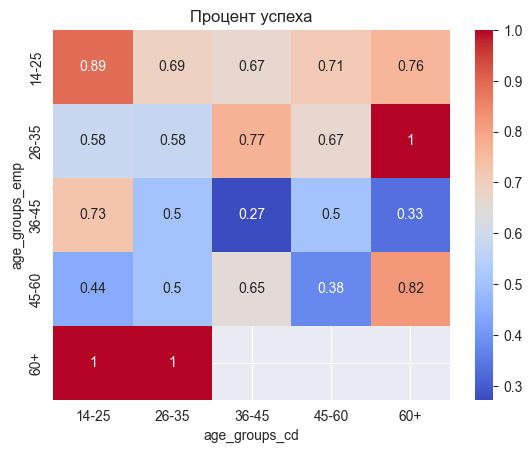

Secured Loan: 13


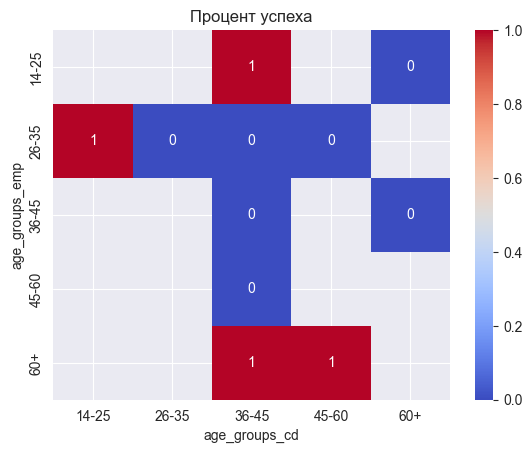

In [189]:
def heatmap(df):
    pivot = df.pivot_table(values='flag', index='age_groups_emp', columns='age_groups_cd', aggfunc='mean')
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title('Процент успеха')
    plt.show()

for i in df_credit['product_cd'].unique():
    now = df_credit[df_credit['product_cd'] == i]
    print(f'{i}: {now.shape[0]}')
    heatmap(now)

In [198]:
def watafak(id):
    c = len(df[df['customer_id'] == id]['employee_id'].tolist())
    return c

emp['emp_in_users'] = emp['employee_id'].apply(watafak)

In [200]:
df_plus_emp['is_easy'] = (df['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])).astype(int)

In [211]:
df_plus_emp[['is_easy', 'flag', 'state_talk_time_sec']].groupby(by=['flag', 'is_easy']).agg(['mean', 'count'])

state_talk_time_sec      
                            mean count
flag is_easy                          
0    0.0               74.106376  3074
     1.0               73.814062  6642
1    0.0              262.957307   609
     1.0              237.093651  1260

In [257]:
df_plus_emp[df_plus_emp['product_cd'] == 'Credit Cards'][[ 'age_groups_emp', 'emp_work_months_cnt']].groupby(by=['age_groups_emp']).agg(['mean', 'count'])

emp_work_months_cnt      
                              mean count
age_groups_emp                          
14-25                     4.694444  2196
26-35                    13.989329  1312
36-45                    34.569028  1369
45-60                    33.859037  1433
60+                      37.046083   434

In [212]:
df_gypotesa_1

,index,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,...,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching,age35
1,21,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,14-25,60+,0,0
2,29,1178,480706447,44.0,M,town,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,36-45,60+,0,1
3,30,1187,397419981,34.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,26-35,14-25,0,0
6,38,1338,68791731,33.0,F,town,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,26-35,60+,0,0
7,49,1708,447394749,18.0,M,town,0.0,0.0,0.0,0.0,...,1,1,0,1,0,0,14-25,36-45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,14771,16372,572944033,NaN,None,town,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,60+,36-45,0,0
7419,14774,16492,473146702,NaN,None,None,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,60+,36-45,0,0
7424,14787,17761,371460142,NaN,None,rural,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,60+,14-25,0,0
7425,14790,18110,525669032,NaN,F,None,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,60+,36-45,0,0


механизм: люди в возрасте 35+ лучше разбираются с кредитными картами и лучше могут объяснить клиентам все вопросы, связаные с кредитными картами;\n
Альтернативный механизм: люди в возрасте до 35 чаще имеют маленький опыт работы и хуже знают нюансы

In [232]:
df_gypotesa_2 = df_gypotesa_1[df_gypotesa_1['emp_work_months_cnt'] >= 0]
percentile25 = np.percentile(df_gypotesa_2['emp_work_months_cnt'].dropna(), 25)
df_gypotesa_2['small_work'] = (df_gypotesa_2['emp_work_months_cnt'] < percentile25).astype(int)
df_gypotesa_2.pivot_table(index='age_groups_emp', values='small_work', aggfunc='sum')

,small_work
age_groups_emp,
14-25,558
26-35,156
36-45,154
45-60,100
60+,7


In [238]:
df_gypotesa_2.shape[0]

5609

In [239]:
contingency_table = pd.crosstab(df_gypotesa_2['small_work'], df_gypotesa_2['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 63.90669992928005
p-value: 1.3045324245585324e-15
Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка


In [242]:
emp.shape[0]

561

In [244]:
df_plus_emp['full_matching'] = df_plus_emp['age_matching'] * df_plus_emp['age_group_matching']

In [246]:
df_plus_emp[['full_matching', 'flag']].groupby(by=['full_matching']).agg(['mean', 'count'])

flag       
                   mean  count
full_matching                 
0              0.163062  12253
1              0.163193   2543

In [252]:
for i in df_plus_emp['product_cd'].unique():
    now = df_plus_emp[df_plus_emp['product_cd'] == i]
    vazhnost = now[now['full_matching'] == 1]['flag'].mean() - now[now['full_matching'] == 0]['flag'].mean()
    print(f'{i}: {now.shape[0]}:\n{vazhnost:.5f}\n')

Credit Cards: 7401:
0.00012

Cash Loan: 2402:
-0.00188

MVNO: 1652:
-0.00226

Casco: 291:
-0.07290

Secured Loan: 435:
-0.00622

Car Loan: 237:
0.11640

Investment: 565:
0.05528

Debit Cards: 1529:
0.04203

Mortgage Insurance: 246:
0.16944

Travel Avia: 5:
nan

Osago: 23:
-0.45000

T-Auto: 2:
nan

Deposit: 8:
0.00000



In [254]:
df_gypotesa_3 = df_plus_emp[df_plus_emp['product_cd'].isin(['Debit Cards', 'Mortgage Insurance'])]
contingency_table = pd.crosstab(df_gypotesa_3['full_matching'], df_gypotesa_3['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 3.596935363504477
p-value: 0.05788618972440724
Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует


In [255]:
emp

,employee_id,emp_gender_cd,emp_age,emp_age_new,emp_children_cnt,emp_work_months_cnt,state_talk_time_sec,emp_mean_flag,time_uspeh,min_age,max_age,lovely_gender_cd,best_product,emp_in_users
0,871.0,M,50.0,48.255814,NaN,69.906977,94.273438,0.124031,335.411765,34.0,43.0,F,Casco,0
1,1731.0,W,36.0,36.000000,NaN,80.750000,113.375000,0.125000,175.000000,46.0,46.0,M,Credit Cards,0
2,2615.0,W,28.0,26.000000,0.0,4.333333,NaN,0.000000,NaN,0.0,0.0,F,Osago,0
3,2645.0,W,46.0,44.000000,NaN,86.000000,58.000000,0.000000,NaN,0.0,0.0,M,Investment,0
4,3021.0,W,54.0,53.045455,NaN,71.378788,179.234375,0.227273,508.866667,35.0,44.0,F,Casco,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,297968.0,W,45.0,45.000000,NaN,0.800000,72.400000,0.600000,61.333333,36.5,40.0,F,Debit Cards,0
557,300152.0,W,18.0,18.000000,NaN,0.000000,40.000000,0.000000,NaN,0.0,0.0,M,Debit Cards,0
558,304414.0,M,19.0,19.000000,NaN,NaN,28.500000,0.000000,NaN,0.0,0.0,M,Investment,0
559,304572.0,W,19.0,19.000000,NaN,0.000000,51.400000,0.600000,53.333333,24.5,40.0,F,Debit Cards,0


In [274]:
credit = ['Credit Cards', 'Cash Loan', 'Secured Loan', 'Car Loan']
df_gypotesa_4 = df_plus_emp[df_plus_emp['product_cd'].isin(credit)]
contingency_table = pd.crosstab(df_gypotesa_4['gender_matching'], df_gypotesa_4['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 1.424013165103212
p-value: 0.23274398360281304
Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует


In [275]:
import pandas as pd
import scipy.stats as stats

filtered_df = df_plus_emp[df_plus_emp['product_cd'].isin(credit)]

# Успешность звонков по возрастным группам
success_by_group = filtered_df.groupby('gender_matching')['flag']

# Тест ANOVA
anova_result = stats.f_oneway(
    filtered_df[filtered_df['gender_matching'] == 1]['flag'],
    filtered_df[filtered_df['gender_matching'] == 0]['flag']
)

print("ANOVA p-value:", anova_result.pvalue)

# Интерпретация
if anova_result.pvalue < 0.05:
    print("Есть статистически значимая разница между возрастными группами.")
else:
    print("Статистически значимой разницы между возрастными группами нет.")


ANOVA p-value: 0.2207041789008141
Статистически значимой разницы между возрастными группами нет.


In [276]:
# Тест Манна-Уитни
mannwhitney_result = stats.mannwhitneyu(
    filtered_df[filtered_df['gender_matching'] == 1]['flag'],
    filtered_df[filtered_df['gender_matching'] == 0]['flag'],
    alternative='two-sided'
)

print("Mann-Whitney U p-value:", mannwhitney_result.pvalue)

# Интерпретация
if mannwhitney_result.pvalue < 0.05:
    print("Есть статистически значимая разница между возрастными группами.")
else:
    print("Статистически значимой разницы между возрастными группами нет.")


Mann-Whitney U p-value: 0.22068991216545508
Статистически значимой разницы между возрастными группами нет.


In [292]:
# Фильтрация звонков для продукта Cash Loan
cash_loan_calls = df_plus_emp[df_plus_emp['product_cd'] == 'Cash Loan']

# Удаление звонков с некорректной длительностью (например, NaN или равной 0)
cash_loan_calls = cash_loan_calls[cash_loan_calls['state_talk_time_sec'] > 300]


In [293]:
# Статистический тест: Успешные и неуспешные звонки
from scipy.stats import mannwhitneyu

successful_calls = cash_loan_calls[cash_loan_calls['flag'] == 1]['state_talk_time_sec']
unsuccessful_calls = cash_loan_calls[cash_loan_calls['flag'] == 0]['state_talk_time_sec']

# Тест на нормальность
from scipy.stats import shapiro

shapiro_success = shapiro(successful_calls)
shapiro_unsuccess = shapiro(unsuccessful_calls)

if shapiro_success.pvalue > 0.05 and shapiro_unsuccess.pvalue > 0.05:
    # Нормально распределенные данные — используем t-тест
    from scipy.stats import ttest_ind
    ttest_result = ttest_ind(successful_calls, unsuccessful_calls)
    print("T-test p-value:", ttest_result.pvalue)
    if ttest_result.pvalue < 0.05:
        print("Длительность разговора статистически влияет на успешность звонков.")
    else:
        print("Статистически значимого влияния длительности разговора нет.")
else:
    # Не нормально распределенные данные — используем Манна-Уитни
    mw_result = mannwhitneyu(successful_calls, unsuccessful_calls, alternative='two-sided')
    print("Mann-Whitney U p-value:", mw_result.pvalue)
    if mw_result.pvalue < 0.05:
        print("Длительность разговора статистически влияет на успешность звонков.")
    else:
        print("Статистически значимого влияния длительности разговора нет.")


Mann-Whitney U p-value: 0.0024434218335928756
Длительность разговора статистически влияет на успешность звонков.


In [298]:
import pandas as pd
import scipy.stats as stats

for i in df_plus_emp['product_cd'].unique():
    
    # Фильтрация только звонков по продукту Cash Loan
    cash_loan_calls = df_plus_emp[df_plus_emp['product_cd'] == i]
    
    # Успешность звонков по группам region_size
    success_rates = cash_loan_calls.groupby('region_size')['flag'].mean()
    
    # Группировка данных для статистического теста
    rural_data = cash_loan_calls[cash_loan_calls['region_size'].isin(['town', 'rural'])]['flag']
    urban_data = cash_loan_calls[cash_loan_calls['region_size'].isin(['urban', 'msk'])]['flag']
    
    # Проверка статистической значимости различий
    try:
        stat, p_value = stats.mannwhitneyu(rural_data, urban_data, alternative='two-sided')
    except ValueError:
        continue
    
    # Вывод результатов
    # print("Средний процент успешных звонков для 'town' и 'rural':", rural_data.mean())
    # print("Средний процент успешных звонков для 'urban' и 'msk':", urban_data.mean())
    # print("Mann-Whitney U p-value:", p_value)
    
    # Интерпретация
    if p_value < 0.05:
        print(i)

Credit Cards
Investment


In [303]:
import pandas as pd
import scipy.stats as stats

# Фильтрация только звонков по продукту Cash Loan
cash_loan_calls = df_plus_emp[df_plus_emp['product_cd'] == 'Credit Cards']

# Успешность звонков по группам region_size
success_rates = cash_loan_calls.groupby('region_size')['flag'].mean()

# Группировка данных для статистического теста
rural_data = cash_loan_calls[cash_loan_calls['region_size'].isin(['town', 'rural'])]['flag']
urban_data = cash_loan_calls[cash_loan_calls['region_size'].isin(['urban', 'msk'])]['flag']

# Проверка статистической значимости различий
stat, p_value = stats.mannwhitneyu(rural_data, urban_data, alternative='two-sided')

# Вывод результатов
print("Средний процент успешных звонков для 'town' и 'rural':", rural_data.mean())
print("Средний процент успешных звонков для 'urban' и 'msk':", urban_data.mean())
print("Mann-Whitney U p-value:", p_value)

# Интерпретация
if p_value < 0.05:
    print(i)

Средний процент успешных звонков для 'town' и 'rural': 0.13898305084745763
Средний процент успешных звонков для 'urban' и 'msk': 0.08353221957040573
Mann-Whitney U p-value: 3.420478822955742e-08
Deposit


In [307]:
cash_loan_calls

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching,is_easy,full_matching
0,23,342879157,27.0,M,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,26-35,45-60,0,1.0,0
2,63,282407696,41.0,M,rural,0.0,1.0,1.0,0.0,1.0,...,0,0,1,0,0,36-45,45-60,0,1.0,0
8,117,509469281,42.0,F,town,0.0,0.0,0.0,0.0,1.0,...,1,0,0,1,0,36-45,26-35,0,0.0,0
21,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,1.0,...,1,0,1,0,0,14-25,60+,0,0.0,0
29,1178,480706447,44.0,M,town,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,0,36-45,60+,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,18077,584331549,NaN,M,town,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,60+,14-25,0,0.0,0
14790,18110,525669032,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,1,0,0,60+,36-45,0,1.0,0
14792,18220,539821879,NaN,NaN,msk,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,60+,14-25,0,1.0,0
14794,18353,476196896,NaN,NaN,urban,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,60+,36-45,0,1.0,0


In [310]:
df_millionnik = df_plus_emp.copy()
df_millionnik['normis_city'] = (df_millionnik['region_size'].isin(['rural', 'town'])).astype(int)
contingency_table = pd.crosstab(df_millionnik['normis_city'], df_millionnik['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 22.87742565516112
p-value: 1.7266788020546464e-06
Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка


In [315]:
import pandas as pd

# Предположим, ваш DataFrame выглядит так:
# df_plus_emp содержит следующие столбцы: ['region', 'flag', 'normis_city', 'clients']

df_millionnik = df_plus_emp.copy()
df_millionnik['normis_city'] = (df_millionnik['region_size'].isin(['rural', 'town'])).astype(int)

# Пример нормировки
def normalize_and_compare(df):
    # Суммируем целевую переменную flag и число клиентов по регионам
    region_summary = df.groupby(['normis_city']).agg({
        'flag': 'count',       # Сумма значений флага в регионе
    }).reset_index()

    # Среднее значение флага для миллионников и немиллионников
    comparison = df['flag'].mean()

    return region_summary, comparison

# Применение функции
region_summary, comparison = normalize_and_compare(df_millionnik)

# Вывод результатов
print("Результаты по регионам:\n", region_summary)
print("\nСредние нормированные значения для миллионников и немиллионников:\n", comparison)


Результаты по регионам:
    normis_city  flag
0            0  8745
1            1  6051

Средние нормированные значения для миллионников и немиллионников:
 0.16308461746417952


In [317]:
df_plus_emp[['region_size', 'income']].dropna()

,region_size,income
1,urban,27662.12
2,rural,15823.50
3,urban,13402.31
4,town,8886.00
5,urban,13739.59
...,...,...
3997,rural,30199.18
3998,rural,9105.51
3999,town,16538.00
4000,urban,9128.50


In [ ]:
import pandas as pdimport matplotlib.pyplot as plt
# Предположим, что у вас уже есть DataFrame df_plus_emp с колонками 'gender_cd' и 'emp_gender_cd'
# df_plus_emp = pd.read_csv('path_to_your_csv_file.csv')
# Подсчитываем количество людей в каждой категории гендераgender_counts = df_plus_emp[['customer_id', 'gender_cd']].value_counts()
gender_counts = df_plus_emp['gender_cd'].value_counts()
# Подсчитываем количество операторов в каждой категории гендераoperator_gender_counts = df_plus_emp['emp_gender_cd'].value_counts()
# Задаем порядок категорий для людей
category_order_people = ['F', 'M']gender_counts = gender_counts.reindex(category_order_people, fill_value=0)
# Задаем порядок категорий для операторов
category_order_operators = ['W', 'M']operator_gender_counts = operator_gender_counts.reindex(category_order_operators, fill_value=0)
# Строим график
plt.figure(figsize=(10, 6))
# Ширина столбцовbar_width = 0.4

# Позиции столбцовr1 = range(len(category_order_people))
r2 = [x + bar_width for x in r1]
# График для количества людей в каждой категории гендераplt.bar(r1, gender_counts.values, color='#0000ff', width=bar_width, label='Количество записей о клиентах', alpha=0.8)
# График для количества операторов в каждой категории гендера
plt.bar(r2, operator_gender_counts.values, color='#ff0000', width=bar_width, label='Количество записей об операторах', alpha=0.8)
# Устанавливаем метки осейplt.xlabel('Гендер')
plt.ylabel('Количество записей')plt.title('Количество записей людей и операторов по гендеру')
plt.xticks([r + bar_width / 2 for r in range(len(category_order_people))], ['Женщины', 'Мужчины'])plt.legend()
plt.xticks(rotation=0)plt.grid(False)
# Сохраняем график
plt.savefig("gender.png")
# Показываем графикplt.show()

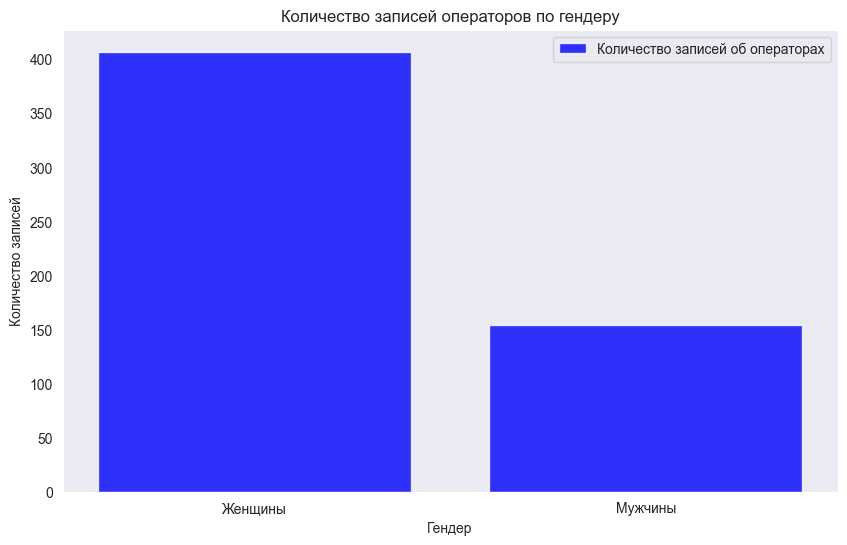

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
# Предположим, что у вас уже есть DataFrame df_plus_emp с колонками 'gender_cd' и 'emp_gender_cd'
# df_plus_emp = pd.read_csv('path_to_your_csv_file.csv')
# Подсчитываем количество людей в каждой категории гендера
gender_counts = df_plus_emp[['customer_id', 'gender_cd', 'flag']].groupby(by=['customer_id', 'gender_cd']).sum().reset_index()
gender_counts = gender_counts['gender_cd'].value_counts()
# Подсчитываем количество операторов в каждой категории гендера
operator_gender_counts = df_plus_emp[['employee_id', 'emp_gender_cd', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).sum().reset_index()
operator_gender_counts = operator_gender_counts['emp_gender_cd'].value_counts()
# Задаем порядок категорий для людей
category_order_people = ['F', 'M']
gender_counts = gender_counts.reindex(category_order_people, fill_value=0)
# Задаем порядок категорий для операторов
category_order_operators = ['W', 'M']
operator_gender_counts = operator_gender_counts.reindex(category_order_operators, fill_value=0)
# Строим график
plt.figure(figsize=(10, 6))
# Ширина столбцов
bar_width = 0.4

# Позиции столбцов
r1 = range(len(category_order_people))
r2 = [x + bar_width for x in r1]
# График для количества людей в каждой категории гендера
# plt.bar(r1, gender_counts.values, color='#0000ff', width=bar_width, label='Количество записей о клиентах', alpha=0.8)
# График для количества операторов в каждой категории гендера
plt.bar(r2, operator_gender_counts.values, color='#0000ff', label='Количество записей об операторах', alpha=0.8)
# Устанавливаем метки осей
plt.xlabel('Гендер')
plt.ylabel('Количество записей')
plt.title('Количество записей операторов по гендеру')
plt.xticks([r + bar_width for r in range(len(category_order_people))], ['Женщины', 'Мужчины'])
plt.legend()
plt.xticks(rotation=0)
plt.grid(False)
# Сохраняем график
plt.savefig("gender.png")
# Показываем график
# plt.show()

In [135]:
operator_gender_counts

emp_gender_cd
W    407
M    154
Name: count, dtype: int64

In [143]:
operator_gender_counts = df_plus_emp[['employee_id', 'emp_gender_cd', 'flag', 'emp_work_months_cnt']].groupby(by=['employee_id', 'emp_gender_cd']).mean().reset_index()

In [ ]:
9.56
12.86

In [33]:
operator_gender_counts['emp_work_months_cnt'].corr(operator_gender_counts['flag'])

NameError: name 'operator_gender_counts' is not defined

In [ ]:
df_plus_emp[df_plus_emp['']]

In [44]:
bd = pd.read_csv('final.csv')
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['hours'] = bd['finish_dttm'].dt.hour
bd['hours']

0        10
1        12
2        13
3         9
4        11
         ..
18686    10
18687    12
18688    11
18689    13
18690     9
Name: hours, Length: 18691, dtype: int32